#### **Welcome to Assignment 4 on Deep Learning.**
In this notebook, you'll have to load pre-trained model and generate captions for a given input Image. 

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

**Acknowledgement:** This assignment is made possible with the help of this awesome pytorch tutorial: https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning

### Image Captioning

**Important:** Download `pretrained_model.zip` and `vocap.zip` files into your notebook root folder before you start the assignment. These can be downloaded from the following link: https://drive.google.com/drive/folders/12O5lTaofxKHcOlYeEEfzVwidUeEdVdAK?usp=sharing

You can use the gdown command to download the zip files or you can do it manually.

In [60]:
# Install torchtext 
!pip install torchtext

In [61]:
# Required imports
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from PIL import Image
from torchvision import transforms 
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

### Question-1

Find out the caption generated by the model when an input image ("image_1.jpg") is being fed to the encoder?

In [62]:
#### YOUR CODE STARTS HERE ####
# Check availability of GPU and set the device accordingly
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
#### YOUR CODE ENDS HERE ####

cpu


In [63]:
# this is a simple wrapper for dealing with the vocabulary! 
# this'll be automatically used when you load the provided vocabulary file
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [64]:

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        #### (2 marks) YOUR CODE STARTS HERE ####
        # load the resnet152 network provided by torchvision
        resnet = models.resnet152(pretrained=True)
        # remove the last FC layer in the network
        modules = list(resnet.children())[:-1]  
        #define a sequential model with the modules obtained above
        self.resnet = nn.Sequential(*modules)
        # define a linear layer with out_features as embed_size
        self.linear =   nn.Linear(resnet.fc.in_features,embed_size)
        #print(resnet.fc.in_features)
        #print(resnet.fc.out_features)
        # define a 1d batch norm layer with embed_size as the number of features and a momentum of 0.01 
        self.bn =   nn.BatchNorm1d(embed_size, momentum=0.01)
        #### YOUR CODE ENDS HERE ####
    def forward(self, images):
        #### (2 marks) YOUR CODE STARTS HERE ####
        # calculate the forward pass in the order of base_model -> linear -> bn
        # reshape features, if necessary
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        #print(features.shape)
        features = self.bn(self.linear(features))
        #### YOUR CODE ENDS HERE ####
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(DecoderRNN, self).__init__()
        self.max_seg_length = max_seq_length
        #### (2 marks) YOUR CODE STARTS HERE ####
        # define an embedding layer with vocab_size as the size of the dictionary
        # and embed_size as the size of each embedding
        self.embed =  nn.Embedding(vocab_size, embed_size)
        # define a LSTM layer with embed_size, hidden_size, num_layers, set batch_first to True
        self.lstm =  nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        # define a linear layer with out features as the vocab size
        self.linear = nn.Linear(hidden_size, vocab_size)
        #### YOUR CODE ENDS HERE ####

    def forward(self, features, captions, lengths):
        #### (2 marks) YOUR CODE STARTS HERE ####
        # get embeddings for the captions
        embeddings = self.embed(captions) 
        # concatenate the features with embeddings
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        #### YOUR CODE ENDS HERE ####
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids


In [65]:

def main(img_path):
    #### (2 marks) YOUR CODE STARTS HERE ####
    # Image preprocessing
    # define the transforms with normalization values: [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    transform = transforms.Compose([ 
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
         # convert to a tensor
         # normalize 
   
    
    # load the vocaulary wrapper file
    with open('vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)

    ## 
    # build encoder with a embed size of 256 (load it in eval mode)
    encoder = EncoderCNN(256).eval()  # eval mode (batchnorm uses moving mean/variance)
    # build decoder with embed_size of 256, hidden_size of 512, vocab_size, 1 layer
    decoder = decoder = DecoderRNN(256, 512, len(vocab), 1)
    encoder = encoder.to(device) 
    decoder = decoder.to(device)
    
    ## 
    # load the pre-trained weights for encoder and decoder
    encoder.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/encoder-5-3000.pkl'))
    decoder.load_state_dict(torch.load('decoder-5-3000.pkl'))

    #### YOUR CODE ENDS HERE ####

    # Prepare an image
    image = Image.open(img_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    image = transform(image).unsqueeze(0)
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    # Print out the image and the generated caption
    print (sentence)
    image = Image.open(img_path)
    plt.imshow(np.asarray(image))

Download image from https://farm6.staticflickr.com/5540/9036468623_61a0344eab_z.jpg and rename it as image_1.JPG


<start> a bus that is parked in a parking lot . <end>


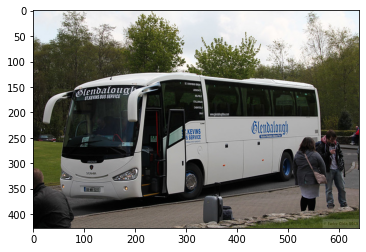

In [66]:
main('image_1.jpg')